# Augmentation du PFR avec les services AWS

## Introduction

Ce notebook permet d'explorer des services d'amazon dans le cadre du projet fil rouge et d'émuler un pipeline de traitement. Pour les traitements, nous explorerons :

* l'extraction du texte d'un pdf avec textract (https://us-west-1.console.aws.amazon.com/textract/home?region=us-west-1#/),
* la reconnaissance des entités nommées avec comprehend (https://us-east-1.console.aws.amazon.com/comprehend/home?region=us-east-1#welcome)


L'infrastructure correspondante est la suivante :



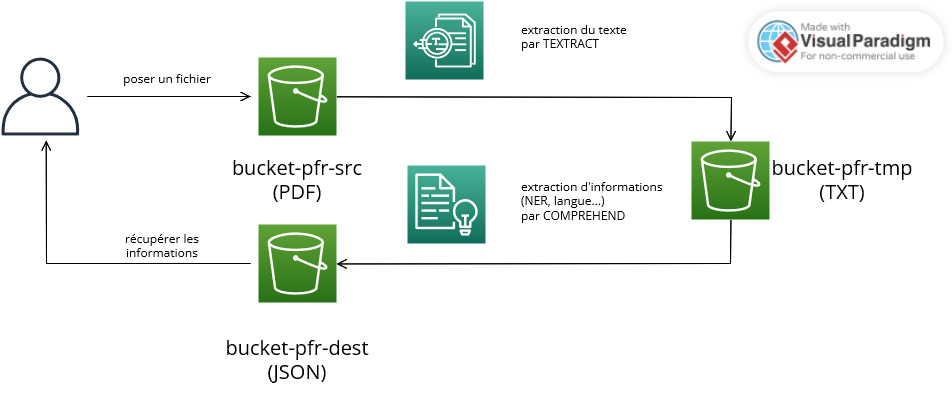

Remarques :
* sauf erreur de ma part, comprehend (le coeur de ce notebook) pouvais être utilisé avec un compte aws academy, ce n'est plus le cas aujourd'hui. Il me semble également que les fonctionnalités sont notablement plus évoluées (meilleurs résultats dans la NER de mémoire), ce qui pourrait être la raison de ce changement. Un compte AWS (normal) est donc nécessaire. (Access key ID doit commencer par AKIA et non ASIA, qui indique une licence temporaire) ;
* en outre, ce notebook ne fonctionne pas sous google colab (refus de création des buckets, qui est possible avec le même notebook en local).

## Installation du SDK Pour AWS en python

In [1]:
!pip install boto3

Les imports et l'initialisation du logger :

In [2]:
import boto3
import random
import shutil
import logging
import sys

logging.basicConfig(format='%(asctime)s | %(levelname)s : %(message)s',
                     level=logging.INFO, stream=sys.stdout)
log = logging.getLogger('knowledge-graph-logger')

## Téléchargement d'un fichier arXiv
Nous prenons l'un des fichiers traités dans les notebooks du projet.

In [3]:
import requests # pour telecharger un fichier

file_to_analyse = "http://arxiv.org/pdf/1512.05986v1"
filename = './'+file_to_analyse[21:]+'.pdf'
# Envoi d'une requête pour récupérer le contenu du PDF
response = requests.get(file_to_analyse)

# Vérification du statut de la réponse
if response.status_code == 200:
    # Récupération du contenu du PDF et enregistrement dans un fichier local   
    with open(filename, 'wb') as f:
        f.write(response.content)
        print('PDF téléchargé avec succès !')
else:
    print('Impossible de télécharger le PDF. Code d\'erreur:', response.status_code)

PDF téléchargé avec succès !


## Création des buckets

Un bucket S3 doit être unique et suivre des règles de nommage (https://docs.aws.amazon.com/AmazonS3/latest/userguide/bucketnamingrules.html).

Dans ce but on va utiliser le numéro de compte et un nombre aléatoire.
Nous allons créer trois buckets de prefix :
* bucket-pfr-src- pour les fichiers pdf à traiter,
* bucket-pfr-tmp- pour le contenu du texte des fichiers sources, extraits via PyPDF2 ou non,
* bucket-pfr-dest- pour les informations extraites (entités nommées typiquement) sous forme JSON.

In [4]:

account_id = boto3.client('sts').get_caller_identity().get('Account')

#bucket name
# Pour les fichiers à traiter
bucket_src = 'bucket-pfr-src-' + account_id + '-' + str(random.randint(0,100000))
# Pour le contenu des fichiers (par extraction directe ou non)
bucket_tmp ='bucket-pfr-tmp-' + account_id + '-' + str(random.randint(0,100000))
bucket_dest ='bucket-pfr-dest-' + account_id + '-' + str(random.randint(0,100000))
log.info(f'bucket name: {bucket_src}')

s3 = boto3.client('s3')
#create of buckets
s3.create_bucket(Bucket=bucket_src)
s3.create_bucket(Bucket=bucket_tmp)
s3.create_bucket(Bucket=bucket_dest)

2023-04-13 13:42:36,146 | INFO : Found credentials in shared credentials file: ~/.aws/credentials
2023-04-13 13:42:36,982 | INFO : bucket name: bucket-pfr-src-644695889890-58981


{'ResponseMetadata': {'RequestId': 'GHXJ81E33THPVDB1',
  'HostId': 'PZm/FYaTsWm4n4pb7mdApC/JWgkcajExLR5VhOW4ofavd1IdI4hlGd/PWBXh5GDM7ZC0TC5wESK+wTCTW7POTFRun2DyBwJrMhHpQcrBUsk=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'PZm/FYaTsWm4n4pb7mdApC/JWgkcajExLR5VhOW4ofavd1IdI4hlGd/PWBXh5GDM7ZC0TC5wESK+wTCTW7POTFRun2DyBwJrMhHpQcrBUsk=',
   'x-amz-request-id': 'GHXJ81E33THPVDB1',
   'date': 'Thu, 13 Apr 2023 11:42:41 GMT',
   'location': '/bucket-pfr-dest-644695889890-9207',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'Location': '/bucket-pfr-dest-644695889890-9207'}

On peut placer le fichier manuellement le fichier dans le bucket (via https://s3.console.aws.amazon.com/s3/bucket/create). Nous allons le faire via du code.

In [5]:
s3.upload_file(filename, bucket_src, filename[2:])

Remarque : 
On peut vérifier la présence des objets dans le bucket :

In [6]:
objects = s3.list_objects_v2(Bucket=bucket_src)

for obj in objects['Contents']:
    print(obj['Key'])

1512.05986v1.pdf


Idéalement, pour émuler un pipeline, chaque étape devrait lister les objets de son bucket et devrait réaliser ses traitements. Nous ne le ferrons pas faute de temps, mais les mécanismes existent bien.

## Utilisation d'Amazon textract

Le nom fait penser à Tesseract utilisé dans le premier notebook, nous allons pouvoir comparer les résultats des exploitations de pdf.

In [7]:
client = boto3.client('textract')
response = client.start_document_text_detection(
                   DocumentLocation={'S3Object': {'Bucket': bucket_src, 'Name':  filename[2:]} })

jobid = response['JobId']
response = client.get_document_text_detection(JobId=jobid)

Le traitement est un peu long, on va donc utiliser un sleep.
Sur un traitement plus industriel, nous devrions utiliser des files d'attentes pour les traitements.


In [8]:
import time

def poll_until_done(job_id):
    while True:
        response = client.get_document_text_detection(JobId=job_id)
        status = response["JobStatus"]
        if status != "IN_PROGRESS":
            return response
        print(".", end="")
        time.sleep(10)

In [9]:
# Usage, given a response from textract.start_document_text_detection:
completion_response = poll_until_done(jobid)

.

Le traitement ayant probablement été réalisé par itérations, on doit recoller les "morceaux" sinon, on ne récupère pas l'ensemble du texte.

In [10]:
def get_all_blocks(job_id):
    blocks = []
    next_token = None
    first = True
    while first or next_token:
        first = False
        kwargs = {"JobId": job_id}
        if next_token:
            kwargs["NextToken"] = next_token
        response = client.get_document_text_detection(**kwargs)
        blocks.extend(response["Blocks"])
        next_token = response.get("NextToken")
    return blocks

In [11]:
content = ""
for item in get_all_blocks(jobid): 
    if item["BlockType"] == "LINE":
        content += item["Text"] + "\n"


In [12]:
print(content)

Can Pretrained Neural Networks Detect Anatomy?
Vlado Menkovski
Zharko Aleksovski
Philips Research
Philips Research
Eindhoven, Netherlands
Eindhoven, Netherlands
vlado.menkovski@philips.com
Sharko.aleksovski@philips.com
Axel Saalbach
Hannes Nickisch
Philips Research
Philips Research
Hamburg, Germany
Hamburg, Germany
axel.saalbach@philips.coom
hannes.nickisch@philips.com
Abstract
Convolutional neural networks demonstrated outstanding empirical results in
computer vision and speech recognition tasks where labeled training data is abun-
dant. In medical imaging, there is a huge variety of possible imaging modalities
and contrasts, where annotated data is usually very scarce. We present two ap-
proaches to deal with this challenge. A network pretrained in a different domain
with abundant data is used as a feature extractor, while a subsequent classifier is
trained on a small target dataset; and a deep architecture trained with heavy aug-
mentation and equipped with sophisticated regularizat

On peut disposer du positionnement des objets (https://docs.aws.amazon.com/textract/latest/dg/text-location.html).
On pourrrait donc obtenir un résultat plus conforme à l'original, mais cela est trop chronophage.

On peut néanmoins faire un comparaison avec le resultat de tesseract :
* le resultat est bien plus exploitable que pour lecture directe du pdf (consulter le premier notebook du projet ou le rapport),
* le resultat est aussi bien que tessearct, les erreurs sont sur les notes de bas de page. 
 * dans le pdf on a : <sup>1</sup>There are 10<sup>6</sup> images in 10<sup>3</sup> classes in the ILSVRC challenge, http://www.image-net.org/challenges/LSVRC.
 * textetract donne : 1There are 106 images in 103 classes in the ILSVRC challenge, ttp://www.image-net.org/challenges/LSVRC
 * tesseract donne : 'There are 10° images in 10° classes in the ILSVRC challenge,
http://www. image-net.org/challenges/LSVRC.

Tesseract et Textract donnent des resultats proches, mais Tesseract est gratuit.


Sauvegardons ce traitement dans le bucket idoine.

In [13]:
filename2 = './'+file_to_analyse[21:]+'.txt'
with open(filename2, 'w') as f:
        f.write(content)
s3.upload_file(filename2, bucket_tmp, filename2[2:])

## Utilisation d'Amazon comprehend

In [15]:
s3 = boto3.client('s3')

# Utilisez la méthode get_object() pour lire l'objet
response = s3.get_object(Bucket=bucket_tmp, Key=filename2[2:])

# Récupérez le contenu de l'objet
text = response['Body'].read()

# Affichez le contenu de l'objet
#print(content)

### Initialisation

In [16]:
# Init the Amazon Comprehend client with boto3
client = boto3.client('comprehend')

### Language detection

L'API permet de reconnaitre la langue dominante d'un texte (voir la liste dans https://docs.aws.amazon.com/comprehend/latest/dg/how-languages.html).

Dans le cadre du projet, il conviendrait de séparer le traitement sur la première page du reste du document.
En effet, la première page est pratiquement toujours en anglais, et parfois la suite de l'article dans une autre langue (voir le rapport du projet).

In [17]:
response = client.detect_dominant_language(
    Text=content) 
lang_code = response['Languages'][0]['LanguageCode']
lang_score = response['Languages'][0]['Score']

print('Dominant Language Code: "{}"'.format(lang_code))
print('Score: {0:.{1}f}'.format(lang_score, 3))


Dominant Language Code: "en"
Score: 0.976


In [18]:
response = client.detect_dominant_language(
    Text="Understanding deep learning via decision boundary") 

print('Dominant Language Code: "{}"'.format(lang_code))
print('Score: {0:.{1}f}'.format(lang_score, 3))

Dominant Language Code: "en"
Score: 0.976


Il s'agit ici du titre d'arXiv:2206.01515. Il est bien en anglais, mais les locutions latines (via) ou les termes qui existent dans plusieurs langues (ici decision, sans accent), peut poser des problèmes.

In [19]:
response = client.detect_dominant_language(
Text="Partition Function Estimation: A Quantitative Study") 

print('Dominant Language Code: "{}"'.format(lang_code))
print('Score: {0:.{1}f}'.format(lang_score, 3))

Dominant Language Code: "en"
Score: 0.976


Il s'agit ici du titre d'arXiv:2105.11132. Encore un bon résultat.

In [20]:
response = client.detect_dominant_language(
Text="Poincaré Heterogeneous Graph Neural Networks for Sequential Recommendation") 

print('Dominant Language Code: "{}"'.format(lang_code))
print('Score: {0:.{1}f}'.format(lang_score, 3))

Dominant Language Code: "en"
Score: 0.976


Il s'agit ici du titre d'arXiv:2205.11233. Encore une réussite, en dépit de l'accent.
La détection de langue fonctionne remarquablement bien, même sur des textes très courts. (Je n'ai pas trouvé de mauvais résultats !).
En revanche il est surprenant que le score soit ici toujours le même.

#### Sentiment Analysis

In [21]:
response = client.detect_sentiment(
    Text=content[:5000],  # 5000 est la taille max par defaut
    LanguageCode=lang_code
)

sentiments = ['Positive', 'Negative', 'Neutral', 'Mixed']

#print('Text: {}\n'.format(text))
print('Sentiment:\t{}'.format(response['Sentiment']))
print('Scores:')
for sentiment in sentiments:
    print('• {0}:\t{1:.{2}f}'.format(sentiment, response['SentimentScore'][sentiment], 3))

Sentiment:	NEUTRAL
Scores:
• Positive:	0.011
• Negative:	0.000
• Neutral:	0.988
• Mixed:	0.000


L'API permet une analyse des sentiments (ici plutôt des polarités) : positive, negative, neutral, ou mixed.
C'est une fonction classique du NLP (voir par exemple BERT de google qui réalise cette tâche avec du deep learning).
Notons qu'ici on a une séparation de neutre (ni positif ni négatif) et de mixte (mélange des deux).
On a donc une implémentation évoluée.

#### Entities Detection

AWS propose une détection des entités nommées ( par exemple "People," "Places," "Locations," etc.)
Nous allons pouvoir comparer les résultats avec ceux de spaCy (voir le notebook correspondant).

Les entités connues d'aws comprehend sont :
* COMMERCIAL_ITEM : A branded product
* DATE : A full date (for example, 11/25/2017), day (Tuesday), month (May), or time (8:30 a.m.)
* EVENT : An event, such as a festival, concert, election, etc.
* LOCATION : A specific location, such as a country, city, lake, building, etc.
* ORGANIZATION : Large organizations, such as a government, company, religion, sports team, etc.
* OTHER : Entities that don't fit into any of the other entity categories
* PERSON : Individuals, groups of people, nicknames, fictional characters
* QUANTITY : A quantified amount, such as currency, percentages, numbers, bytes, etc.
* TITLE :An official name given to any creation or creative work, such as movies, books, songs, etc.

On peut déjà noter que Spacy en propose un peu plus mais par exemple c'est plutot LOCATION qui est découpé en trois entités différentes. (Cela dit, c'est un moyen pour avoir une meilleure performance coté AWS.)


### Sur le début de l'article

In [22]:
response = client.detect_entities(
    Text=content[:1200],
    LanguageCode=lang_code
)

In [23]:
for obj in response['Entities']:
    print (str(obj["Score"])[:5],obj["Type"],obj["Text"],obj['BeginOffset'],obj['EndOffset'])

0.998 PERSON Vlado Menkovski 47 62
0.969 PERSON Zharko Aleksovski 63 80
0.885 ORGANIZATION Philips Research
Philips Research 81 114
0.969 LOCATION Eindhoven, Netherlands 115 137
0.912 LOCATION Eindhoven, Netherlands 138 160
0.989 OTHER vlado.menkovski@philips.com 161 188
0.763 OTHER Sharko.aleksovski@philips.com 189 218
0.997 PERSON Axel Saalbach 219 232
0.985 PERSON Hannes Nickisch 233 248
0.986 ORGANIZATION Philips Research 249 265
0.743 ORGANIZATION Philips Research 266 282
0.968 LOCATION Hamburg, Germany 283 299
0.972 LOCATION Hamburg, Germany 300 316
0.916 OTHER axel.saalbach@philips.coom 317 343
0.964 OTHER hannes.nickisch@philips.com 344 371
0.766 QUANTITY two ap-
proaches 691 707


Le résultat est bien meilleur qu'avec spaCy :
* tous les auteurs sont bien trouvés,
* le titre n'est pas reconnu comme une organisation, mais pas commen un titre,
* les entités nommées ne changent pas de type

### Pour la bibliographie

In [24]:
print(content[5833:7699])

References
[1] C. Cortes and V. Vapnik. Support-vector networks. Machine learning, 20(3):273-297, 1995.
[2] K. He, X. Zhang, S. Ren, and J. Sun. Delving deep into rectifiers: Surpassing human-level
performance on imagenet classification. arXiv preprint arXiv:1502.01852, 2015.
[3] G. Hinton, L. Deng, D. Yu, G. E. Dahl, A.-r. Mohamed, N. Jaitly, A. Senior, V. Vanhoucke,
P. Nguyen, T. N. Sainath, et al. Deep neural networks for acoustic modeling in speech recogni-
tion: The shared views of four research groups. Signal Processing Magazine, IEEE, 29(6):82-
97, 2012.
2
htp://www.imageclef.org/2009/medanno
2
[4] S. Ioffe and C. Szegedy. Batch normalization: Accelerating deep network training by reducing
internal covariate shift. arXiv preprint arXiv: 1502.03167, 2015.
[5] A. Krizhevsky, I. Sutskever, and G. E. Hinton. Imagenet classification with deep convolutional
neural networks. In Advances in Neural Information Processing Systems 25 (NIPS), 2012.
[6] P. Sermanet, D. Eigen, X. Zhang, M. Ma

In [25]:
response = client.detect_entities(
    Text=content[5833:7699],
    LanguageCode=lang_code
)


In [26]:
for obj in response['Entities']:
    print (str(obj["Score"])[:5],obj["Type"],obj["Text"],obj['BeginOffset'],obj['EndOffset'])

0.974 PERSON C. Cortes 15 24
0.925 PERSON V. Vapnik 29 38
0.710 OTHER 20 83 85
0.753 OTHER 3):273-297 86 96
0.981 DATE 1995 98 102
0.994 PERSON K. He 108 113
0.841 PERSON X. Zhang 115 123
0.951 PERSON S. Ren 125 131
0.994 PERSON J. Sun 137 143
0.975 DATE 2015 271 275
0.802 PERSON G. Hinton, 281 291
0.817 PERSON L. Deng, D. Yu 292 306
0.927 PERSON G. E. Dahl 308 318
0.852 PERSON A.-r. Mohamed 320 333
0.954 PERSON N. Jaitly 335 344
0.838 PERSON A. Senior 346 355
0.995 PERSON V. Vanhoucke 357 369
0.989 PERSON P. Nguyen 371 380
0.985 PERSON T. N. Sainath 382 395
0.572 TITLE Signal Processing Magazine 514 540
0.703 ORGANIZATION IEEE 542 546
0.884 OTHER 29(6):82-
97 548 560
0.966 DATE 2012 562 566
0.994 PERSON S. Ioffe 613 621
0.995 PERSON C. Szegedy 626 636
0.931 OTHER 1502.03167 754 764
0.991 DATE 2015 766 770
0.996 PERSON A. Krizhevsky 776 789
0.996 PERSON I. Sutskever 791 803
0.997 PERSON G. E. Hinton 809 821
0.817 TITLE In Advances in Neural Information Processing Systems 888 940
0.505 

Le résultat est beaucoup plus propre qu'avec spaCy :
* Tous les auteurs sont bien retrouvées,
* san diego est bien associé à CA,
* les dates sont bonnes.
En revanche, les titres et les évènements semblent plus aléatoires. (D'ailleurs pourquoi n'a t'on pas de titre dans le début de l'article ?)
Pour une exploitation, on pourrait imaginer de pouvoir extraire la bibliographie car on retrouve bien des blocs auteurs / date. Mais pour aller plus loin il conviendrait d'abord d'explorer la personnalisation de la recherche.
Faute de temps nous ne le ferons pas.

Pour finir, l'émulation d'un pipeline sauvegardons le résultat au format json dans le bucket idoine.

In [27]:
import json

filename3 = './'+file_to_analyse[21:]+'.json'
with open(filename3, 'w') as f:
        json.dump(response['Entities'], f)

s3.upload_file(filename3, bucket_dest, filename3[2:])

Il n'y a pas de message d'erreur, mais on peut également vérifier via l'interface AWS que le fichier est bien créer.

## Autres fonctionnalités

Amazon Comprehend propose une fonctionnalité de "Topic Modeling".
C'est un sujet complexe, déjà exploré dans un notebook dédié (basé sur gensim).
Faute de temps, nous ne l'explorerons pas.

## Nettoyage

Détruisons les ressources créées dont nous n'avons plus besoin.


In [28]:
def delete_objects(client_s3,bucket_name):
    objects = client_s3.list_objects_v2(Bucket=bucket_name)
    for obj in objects['Contents']:
        #print(obj)
        client_s3.delete_object(Bucket=bucket_name, Key=obj['Key'])
                                
def destroy_bucket(client_s3,bucket_name):
    delete_objects(client_s3,bucket_name)
    client_s3.delete_bucket(Bucket=bucket_name)

In [29]:
destroy_bucket(s3,bucket_src)
destroy_bucket(s3,bucket_tmp)
destroy_bucket(s3,bucket_dest)

## Conclusions
### Pour aller plus loin
Ce notebook peut être étendu de nombreuses façons :
* Nous n'avons pas testé ici d'article avec des caractères exotiques (typiquement du russe!) ;
* AWS présente de nombreux tutoriaux pour l'utilisation de ses services :
 * nous n'avons pas testé la création de droits, 
 * pas de base de données (il y a une BDD orientée graphe proche de Neo4j),
 * pas d'utilisation du machine learning.
Une exploration des services aws via terraform nous semblait plus opportune.


### Problématique de cout

Le cout d'aws comprehend est décrit dans https://aws.amazon.com/fr/comprehend/pricing/. Typiquement, pour 100 caractères (une unité) et jusqu'à 10M d'unités, la reconnaissance d'entités nommées revient à 0.0001 USD.

Notre corpus (rubrique computer science / AI du dépôt arXiv) est constitué de plus de 50 000 articles de plusieurs pages. Considérons que l'article utilisé dans ce notebook est représentatif (il ne fait que trois pages, ce qui semble peu). On a alors un cout total de 400 USD. Cela fait beaucoup, même si le résultat, sans réelle customisation est bien meilleur qu'avec les outils gratuits.
Si la customisation pour un résultat industriel est rapide (ce qui n'est pas certain), ainsi l'emploi d'AWS est utile. Sinon, la personalisation des outils libres est déjà bien documentée (et commencé dans le notebook dédié à spaCy).

Pour textrac, le cout (pour moins d'1M d'unités de 1 000 pages) est de 1.5 USD. Pour une moyenne de 3 pages on a un cout de 225 USD. Si demain textrac reconnait les indices et exposants (dont nous avons besoin pour extraire les affiliations des auteurs des textes) alors cela peut valoir le cout.

On retrouve ici une conclusion similaire à celle de https://blog.ippon.fr/2022/09/29/classifiez-facilement-du-texte-avec-aws-comprehed/ (site présenté par conférencier de mastère et ancien du mastère SIO).

Remarque, je ne peux pas donner le cout de ce notebook, vu qu'aws demande 24h avant de donner l'accès aux informations de cout suite à la création d'un compte !